In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations
import pandas as pd
import time
from numba import jit
from functools import lru_cache

# Rao-Blackwellization of the Accept-Reject algorithm

Use this cell to define the function target, the distribution target, using scipy otherwise it won't work. 
Since we want to estimate $\mathbb{E}[h(x)]$, we also need to define both h and the true mean. The functions h will be used in the comparative analysis part of this notebook. For the first test function, we will simply compute the mean of f 

In [4]:
f = stats.gamma(2.70, scale=1 / 2.70)
g = stats.gamma(2,scale=1/1.78)

#To compute the mean of f 
def h1(x):
    return x
true_mean1 = 1 #mean of f

#To compute tail probability of f
def h2(x):
    return np.where(x>2.17,1,0) #2.17 choosen so that the P(x>2.17)=0.05
true_mean2 = 0.05 


## The accept-reject algorithm : 

Accept rate: 30.49%


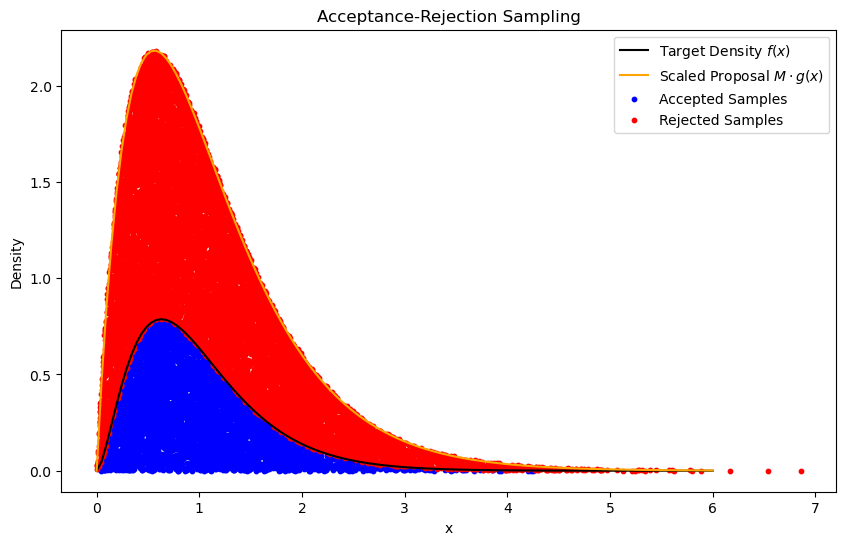

In [6]:
# Parameters
n = 5000
M = 1/0.3  # M = 1/Acceptance_rate

# Storage for accepted and rejected samples
acceptx, rejetx = [], []
accepty, rejety = [], []

# Generate samples using Accept-Reject method
while len(acceptx) < n:
    y = g.rvs()
    u = np.random.uniform()
    if u < f.pdf(y) / (M * g.pdf(y)):
        acceptx.append(y)
        accepty.append(u * M * g.pdf(y))
    else: 
        rejetx.append(y)
        rejety.append(u * M * g.pdf(y))

# Plot the results
xx = np.linspace(0, 6, 125)
accept_rate = 100 * len(acceptx) / (len(acceptx) + len(rejetx))
print(f"Accept rate: {accept_rate:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(xx, f.pdf(xx), label=r'Target Density $f(x)$', color='black')
plt.plot(xx, M * g.pdf(xx), label=r'Scaled Proposal $M \cdot g(x)$', color='orange')
plt.scatter(acceptx, accepty, color='blue', s=10, label='Accepted Samples')
plt.scatter(rejetx, rejety, color='red', s=10, label='Rejected Samples')

# Add title and labels
plt.title("Acceptance-Rejection Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()


#### Optimized version of the Accept-Reject Algorithm 
This versions takes advantage of numpy vectorization to generate the maximum amount of random variable needed and do every computations all at once. The 'remaining_needed' variable adjust itself to ensure that we are not generating wasted random variables. 

In [8]:
#Simulation of the accepted and proposed sample using AR 
def Accept_Reject(t,M):
    sample_accept = []  
    sample_proposal = []  
    while len(sample_accept) < t:
        
        # Calculate the required batch size based on remaining needed samples
        remaining_needed = t - len(sample_accept)
        batch_size = remaining_needed
        
        y = g.rvs(size=batch_size)
        u = np.random.uniform(size=batch_size)
        
        # Calculate acceptance condition in bulk
        accepted = u < f.pdf(y) / (M * g.pdf(y))
        
        # Append all proposals to sample_proposal and only accepted ones to sample_accept
        sample_proposal.extend(y)
        sample_accept.extend(y[accepted])

    return sample_accept, sample_proposal

### Naïve Implementation of the Rao-Blackwellized estimator (with the permutation) 
This is the code for the non-recursive version of p_i of the which is very (very) slow to compute because of the permutations. Try to keep the parameters  low and the acceptance rate, or else it will take a very long time to compute ! 

In [10]:
#Parameters 
number_of_samples = 100
t = 4 #Size of the accepted sample # Keep it low  
M = 1/0.3  # M = 1/acceptance_rate

samples_accept = []
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = Accept_Reject(t,M)
    samples_accept.append(accept)
    samples_proposal.append(proposal)

start_time = time.time()
compteur = 0 
res = []
for j in range(len(samples_proposal)) : 
    sample = samples_proposal[j]
    est = 0 
    sample_array = np.array(sample)
    n = len(sample) 
    weights = f.pdf(sample_array) / (M * g.pdf(sample_array))

    #Calculate denominator
    den = 0
    indices = np.array([idx for idx in range(n-1)])
    for comb in combinations(indices, t-1):
        selected_indices = list(comb)
        selected_weights = weights[selected_indices]
        complement_indices = [x for x in indices if x not in selected_indices]
        complement_weights = weights[complement_indices]
        den += np.prod(selected_weights) * np.prod(1 - complement_weights)
     
    for i in range(n-1):

        #Calculate numerator
        num = 0
        indices = np.array([idx for idx in range(n-1) if idx != i])
        for comb in combinations(indices, t-2):
            selected_indices = list(comb)
            selected_weights = weights[selected_indices]
            complement_indices = [x for x in indices if x not in selected_indices]
            complement_weights = weights[complement_indices]
            num += weights[i] * np.prod(selected_weights) * np.prod(1 - complement_weights)

        est+= (num/den)*sample_array[i]/t 
    est+= sample_array[n-1]/t 
    res.append(est)
    print(f"Progress: {100*(compteur+1)/len(samples_proposal)}%", end='\r')
    compteur+=1

end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

print("")        
# Empirical mean and variance calculations
samples_mean = [np.mean(x) for x in samples_accept]
true_mean = true_mean1

print(f"Target mean: {true_mean}")
print(f"Acceptance Rate: {100*(1/M):.2f}%\n")
print(f"Classic MC empirical average mean: {np.mean(samples_mean):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res):.5f}\n")
print(f"Classic MC variance of the empirical mean: {np.var(samples_mean):.5f}")
print(f"Rao-Blackwell variance empirical mean: {np.var(res):.5f}\n")

classic_mc_mse = np.mean((np.array(samples_mean) - true_mean)**2)
rao_blackwell_mse = np.mean((np.array(res) - true_mean)**2)
mse_decrease = classic_mc_mse - rao_blackwell_mse
percent_decrease = (mse_decrease / classic_mc_mse) * 100

print(f"Classic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Percentage decrease in MSE: {percent_decrease:.2f}%")
print(" ")
print(f"Average time to compute : {loop_time}s")

Progress: 100.0%
Target mean: 1
Acceptance Rate: 30.00%

Classic MC empirical average mean: 0.98731
Rao-Blackwell empirical average mean: 1.03933

Classic MC variance of the empirical mean: 0.08683
Rao-Blackwell variance empirical mean: 0.05305

Classic MC MSE: 0.08699
Rao-Blackwell MSE: 0.05460
Percentage decrease in MSE: 37.23%
 
Average time to compute : 0.012337522506713867s


### Recursive Implementation of the Rao-Blackwellized estimator 
#### First recursive implementation, faster than the function using permutation but still quite slow.

In [12]:
#Rao-Blackwellized estimator computed using the recursive sequence 
#No numpy used because numpy array cannot be cached, and this function is very slow without caching 
@lru_cache(maxsize=None)
def w_i(y):
    if isinstance(y, tuple):
        y = np.array(y)  # Convert tuple back to array if passed as a tuple
    return f.pdf(y) / (M * g.pdf(y))


@lru_cache(maxsize=None)
def S(k, m, sample_hash):
    # Convert hash back to array for processing, if passed as a tuple
    sample = np.array(sample_hash) if isinstance(sample_hash, tuple) else sample_hash

    if k == 0:
        temp = 1
        for j in range(m):
            temp *= (1 - w_i(sample[j]))
        return temp

    if k == m:
        temp = 1
        for j in range(m):
            temp *= w_i(sample[j])
        return temp

    return (w_i(sample[m-1]) * S(k-1, m-1, tuple(sample)) +
            (1 - w_i(sample[m-1])) * S(k, m-1, tuple(sample)))


def clear_cache():
    w_i.cache_clear()
    S.cache_clear()



# Parameters 
number_of_samples = 500
t = 20  # Size of the accepted sample
M = 1/0.8 # M = 1/Acceptance_Rate 

#Generate AR samples
samples_accept = []
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = Accept_Reject(t, M)
    samples_accept.append(accept)
    samples_proposal.append(proposal)


samples = samples_proposal
start_time = time.time()
res = []
for j,sample in enumerate(samples):
    estimateur = 0
    sample_tuple1 = tuple(sample)
    n = len(sample)
    denominator = S(t-1, n-1, sample_tuple1)
    for i in range(n-1):    
        sample_tuple2 = tuple(np.delete(sample,i)) #Sample without Y_i 
        numerator = w_i(sample[i])*S(t-2, n-2, sample_tuple2)
        estimateur+= (numerator / denominator)*sample[i]/t
    estimateur+= sample[n-1]/t
    res.append(estimateur)
    clear_cache() #To avoid memory overflow
    print(f"Progress: {100*(j+1)/len(samples)}%", end='\r')

end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

samples_mean = [np.mean(x) for x in samples_accept] 

print("")
true_mean = true_mean1
print(f"target mean : {true_mean}")
print(f"Acceptance Rate: {100*(1/M):.2f}%\n")
print(f"Classic MC empirical average mean : {np.mean(samples_mean)}")
print(f"Rao Blackwell empirical average mean : {np.mean(res)}")
print("")
print(f"Classic MC variance of the empirical mean : {np.var(samples_mean)}")
print(f"Rao Blackwell variance empirical mean : {np.var(res)}")
print("")
classic_mc_mse = np.mean((np.array(samples_mean) - true_mean)**2)
rao_blackwell_mse = np.mean((np.array(res) - true_mean)**2)
print(f"Classic MC MSE : {classic_mc_mse}")
print(f"Rao Blackwell MSE : {rao_blackwell_mse}")
mse_decrease = classic_mc_mse - rao_blackwell_mse
percent_decrease = (mse_decrease / classic_mc_mse) * 100
print(f"Decrease in MSE: {mse_decrease}")
print(f"Percentage decrease in MSE: {percent_decrease:.2f}%")

print(" ")
print(f"Average time to compute : {loop_time}s")

Progress: 100.0%
target mean : 1
Classic MC empirical average mean : 0.9990531742811624
Rao Blackwell empirical average mean : 1.00064228755208

Classic MC variance of the empirical mean : 0.01894766892291144
Rao Blackwell variance empirical mean : 0.01226419909033816

Classic MC MSE : 0.018948565401853287
Rao Blackwell MSE : 0.01226461162363772
Decrease in MSE: 0.006683953778215568
Percentage decrease in MSE: 35.27%
 
Average time to compute : 0.016729906558990478s


#### Optimized implementation using Matrix : 
This version is much faster, takes full advantage of Numpy and jit to speed up the process

In [14]:
@jit(nopython=True)
def iterative_S(n, t, weights):
    S_matrix = np.zeros((t+1, n))
    S_matrix[0, :] = 1  # Base case for k=0
    
    for m in range(1, n+1):
        weight_m1 = weights[m-1]

        #Multiply last columns by w_m to get new columns
        S_matrix[:, m] = S_matrix[:, m-1] * (1 - weight_m1)

        #add the product of the last column, shifted by 1 toward the bottom, by 1-w_m to the new columns
        S_matrix[1:t+1, m] += weight_m1 * S_matrix[:t, m-1]
        
    return S_matrix


def Rao_Blackwell_estimator(sample, t, M, f, g,h):
    n = len(sample)
    weights = f.pdf(sample) / (M * g.pdf(sample))
    
    # Compute S matrix of size (t,n) with iterative_S function
    S_matrix = iterative_S(n, t-1, weights)

    #The result is given by the value on the bottom right of the matrix
    denominator = S_matrix[t-1, n-1]

    # Initialize estimator with the last element's contribution
    estimator = h(sample[-1]) / t
    
    
    for i in range(n-1):
        # Remove Y_i to calculate S^i_k(m) 
        sub_weights = np.delete(weights, i)
        sub_S_matrix = iterative_S(n-1, t-2, sub_weights)
        
        numerator = weights[i] * sub_S_matrix[t-2, n-2]
        estimator += (numerator / denominator) * h(sample[i]) / t

    return estimator

def Monte_Carlo_estimator(sample,h):
    return np.mean(h(np.array(sample)))

In [15]:
# Parameters 
number_of_samples = 1000
t = 50  # Size of the accepted sample
M = 1/0.5 # M = 1/Acceptance_Rate 

h = h1 # function h used 
true_mean = true_mean1 #mean corresponding the h choosed

#Generate AR samples
samples_accept = []
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = Accept_Reject(t, M)
    samples_accept.append(accept)
    samples_proposal.append(proposal)


start_time = time.time()
#Compute RB estimator
res_MC = []
res_RB = []
for j, sample in enumerate(samples_proposal):
    res_MC.append(Monte_Carlo_estimator(np.array(samples_accept[j]),h))
    res_RB.append(Rao_Blackwell_estimator(sample,t,M,f,g,h))
    print(f"Progress: {100 * (j + 1) / len(samples_proposal):.2f}%", end='\r')


end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples


# Compute Statistics
print("")
print(f"Target mean: {true_mean:.5f}")
print(f"Acceptance Rate: {100*(1/M):.2f}%\n")
print(f"Classic MC empirical average mean: {np.mean(res_MC):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res_RB):.5f}\n")
print(f"Classic MC variance of the empirical mean: {np.var(res_MC):.5f}")
print(f"Rao-Blackwell variance empirical mean: {np.var(res_RB):.5f}\n")

classic_mc_mse = np.mean((np.array(res_MC) - true_mean)**2)
rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean)**2)
mse_decrease = classic_mc_mse - rao_blackwell_mse
percent_decrease = (mse_decrease / classic_mc_mse) * 100

print(f"Classic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Percentage decrease in MSE: {percent_decrease:.2f}%")
print(" ")
print(f"Average time to compute : {loop_time}s")

Progress: 100.00%
Target mean: 1.00000
Acceptance Rate: 50.00%

Classic MC empirical average mean: 1.00110
Rao-Blackwell empirical average mean: 1.00039

Classic MC variance of the empirical mean: 0.00811
Rao-Blackwell variance empirical mean: 0.00316

Classic MC MSE: 0.00811
Rao-Blackwell MSE: 0.00316
Percentage decrease in MSE: 61.04%
 
Average time to compute : 0.0029400639533996584s


## Comparative Analysis of Estimation Techniques: Classic Monte Carlo and Rao-Blackwell :

In [17]:
# Parameters
sample_sizes = [5, 10, 15, 20, 30, 40, 50, 100]
number_of_samples = 20000
M_values = [1/0.8, 1/0.3]

# Matrices to store statistics for each M and h value
Matrix_res_08_h1 = np.zeros((len(sample_sizes), 5)) 
Matrix_res_03_h1 = np.zeros((len(sample_sizes), 5)) 
Matrix_res_08_h2 = np.zeros((len(sample_sizes), 5))  
Matrix_res_03_h2 = np.zeros((len(sample_sizes), 5))  

compteur=1
for h,true_mean in zip([h1,h2],[true_mean1,true_mean2]): #Loop over h1 and h2
# Loop over each M value
    for M_index, M in enumerate(M_values):
        if true_mean == true_mean1:
            result_matrix = Matrix_res_08_h1 if M_index == 0 else Matrix_res_03_h1  # Select correct matrix
        else : 
            result_matrix = Matrix_res_08_h2 if M_index == 0 else Matrix_res_03_h2  # Select correct matrix
    
        for c, t in enumerate(sample_sizes):  # Loop over different sample sizes
            res_RB = []
            res_MC = []
    
            # Generate samples of size t
            samples_accept = []
            samples_proposal = []
            for _ in range(number_of_samples):
                accept, proposal = Accept_Reject(t, M)
                samples_accept.append(accept)
                samples_proposal.append(proposal)
    
            # Compute estimators
            for j, sample in enumerate(samples_proposal):
                res_RB.append(Rao_Blackwell_estimator(sample, t, M, f, g,h))
                res_MC.append(Monte_Carlo_estimator(np.array(samples_accept[j]),h))
    
                # Progress display
                progress_message = f"{compteur}/{2} acceptance rate={1/M:.2f}, Size={t}, Progress: {100 * (j + 1) / number_of_samples:.2f}%"
                print(progress_message.ljust(60), end='\r')
    
            # Compute statistics
            result_matrix[c, 0] = np.mean(res_MC)  # Mean of classic MC results
            result_matrix[c, 1] = np.mean(res_RB)  # Mean of Rao-Blackwell results
    
            classic_mc_mse = np.mean((np.array(res_MC) - true_mean)**2)
            rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean)**2)
    
            result_matrix[c, 2] = classic_mc_mse
            result_matrix[c, 3] = rao_blackwell_mse
    
            # Compute MSE reduction
            mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
            percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100 if classic_mc_mse > 0 else 0
            result_matrix[c, 4] = percent_decrease_rb
    compteur+=1


#### Estimation of a gamma mean = 1, using Accept-Reject with acceptance rate 0.8 based on 10000 simulations

In [19]:
results = [
    'AR estimate',
    'RB estimate',
    'AR MSE',
    'RB MSE',
    'Decrease in MSE (%)']

df_results = pd.DataFrame(Matrix_res_08_h1, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,AR estimate,RB estimate,AR MSE,RB MSE,Decrease in MSE (%)
Sample size,,,,,
5,1.00101,1.00010,0.07434,0.05842,21.41938
10,1.00273,1.00255,0.03768,0.02712,28.02783
15,1.00150,1.00055,0.02477,0.01731,30.13729
20,1.00096,1.00072,0.01848,0.01268,31.40491
30,0.99951,0.99961,0.01257,0.00842,33.05059
40,1.00163,1.00119,0.00923,0.00618,33.05079
50,0.99997,0.99983,0.00753,0.00490,34.84310
100,1.00018,1.00042,0.00372,0.00244,34.46231


#### Estimation of a gamma mean = 1, using Accept-Reject with acceptance rate 0.3 based on 10000 simulations

In [21]:
df_results = pd.DataFrame(Matrix_res_03_h1, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,AR estimate,RB estimate,AR MSE,RB MSE,Decrease in MSE (%)
Sample size,,,,,
5,1.00314,1.00117,0.07475,0.02863,61.70396
10,1.00063,1.00035,0.03705,0.01141,69.20731
15,0.99884,0.99925,0.02445,0.00689,71.81180
20,0.99966,1.00053,0.01831,0.00489,73.31111
30,1.00077,0.99979,0.01233,0.00310,74.82862
40,0.99923,1.00017,0.00927,0.00228,75.42825
50,0.99993,1.00031,0.00753,0.00180,76.09920
100,0.99949,0.99998,0.00368,0.00088,76.17110


#### Estimation of a gamma tail probability 0.05, using Accept-Reject with acceptance rate 0.8 based on 10000 simulations

In [23]:
df_results = pd.DataFrame(Matrix_res_08_h2, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,AR estimate,RB estimate,AR MSE,RB MSE,Decrease in MSE (%)
Sample size,,,,,
5,0.05012,0.04998,0.00974,0.00700,28.09564
10,0.04999,0.04944,0.00465,0.00290,37.54981
15,0.04982,0.04977,0.00321,0.00183,42.95211
20,0.04918,0.04933,0.00234,0.00132,43.75747
30,0.04925,0.04942,0.00160,0.00087,45.64394
40,0.04956,0.04928,0.00116,0.00063,45.90248
50,0.04899,0.04919,0.00094,0.00050,46.80049
100,0.04945,0.04935,0.00047,0.00025,47.12943


#### Estimation of a gamma tail probability 0.05, using Accept-Reject with acceptance rate 0.3 based on 10000 simulations

In [25]:
df_results = pd.DataFrame(Matrix_res_03_h2, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,AR estimate,RB estimate,AR MSE,RB MSE,Decrease in MSE (%)
Sample size,,,,,
5,0.05010,0.04920,0.00972,0.00328,66.22077
10,0.04982,0.04967,0.00464,0.00124,73.28640
15,0.04954,0.04930,0.00310,0.00070,77.30592
20,0.04960,0.04935,0.00238,0.00051,78.68996
30,0.04930,0.04919,0.00157,0.00031,80.18107
40,0.04956,0.04930,0.00118,0.00023,80.68109
50,0.04884,0.04926,0.00094,0.00018,81.06367
100,0.04926,0.04942,0.00047,0.00009,81.77469


#### How many more sample do we have to generate using AR to achieve the same MSE as the Rao-Blackwell estimator with samples size = 100 ?

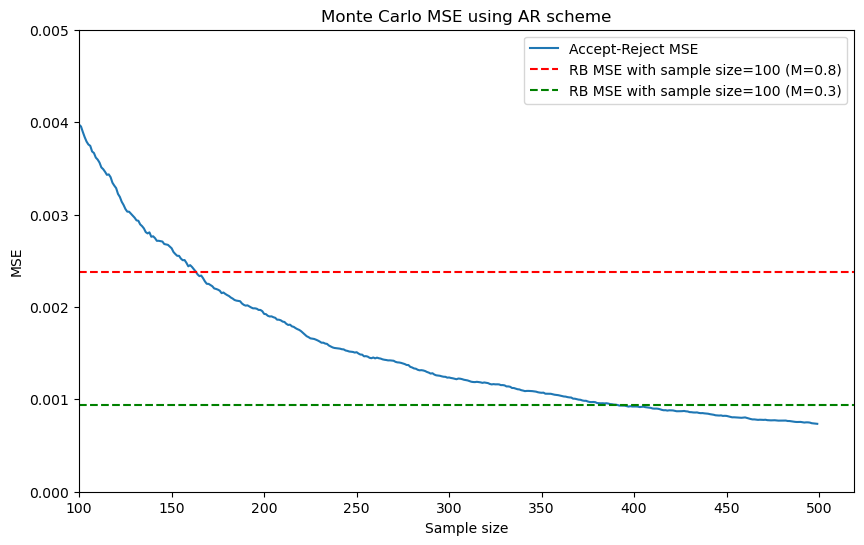

In [27]:
# Parameters :
tt = np.arange(100, 500, 1)
MSE = [0.00238, 0.00094]  # M values with corresponding Rao-Blackwell MSEs
number_of_samples = 1000
h = h1
true_mean = true_mean1


mse_mh = np.zeros(len(tt))

for j in range(number_of_samples):
    accept, _ = Accept_Reject(tt[-1],1/0.8) 
    
    # For each t in tt, calculate MSE from the start of the chain up to t
    for i,t in enumerate(tt):
        subset_accept = accept[:t]
        MC_MSE = ((Monte_Carlo_estimator(subset_accept,h) - true_mean) ** 2)/number_of_samples
        mse_mh[i]+= MC_MSE

    # Progress indicator
    progress = 100 * (j + 1) / number_of_samples
    print(f"Progress: {progress:.2f}%".ljust(50), end='\r')

    
plt.figure(figsize=(10, 6))
plt.plot(tt, mse_mh, label=f'Accept-Reject MSE')
plt.axhline(y=MSE[0], color='red', linestyle='--', label=f'RB MSE with sample size=100 (M={0.8})')
plt.axhline(y=MSE[1], color='green', linestyle='--', label=f'RB MSE with sample size=100 (M={0.3})')
plt.legend()
plt.ylim(0, 0.005)
plt.xlim(100)
plt.xlabel('Sample size')
plt.ylabel('MSE')
plt.title(f"Monte Carlo MSE using AR scheme")
plt.show()


#### Computation time comparison for both estimator

In [29]:
# Parameters 
Ms = [1/0.8, 1/0.3]
size = [150, 400]
number_of_samples = 1000 

h = h1
true_mean = true_mean1

results = []

# Classic MC
for s, M in zip(size, Ms):
    start_time = time.time()
    mse_classic_mc = 0  
    
    # Calculate mean for accepted samples and accumulate MSE
    for i in range(number_of_samples):
        accept, _ = Accept_Reject(s, M)
        mc_estimator = Monte_Carlo_estimator(np.array(accept),h)
        mse_classic_mc += (mc_estimator - true_mean) ** 2  # Accumulate squared error
        
        print(f"Classic MC Progress (Size={s}, Rate={1/M}): {100 * (i + 1) / number_of_samples:.2f}%", end='\r')

    mse_classic_mc /= number_of_samples 
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples
    
    results.append({
        "Estimator": "Classic MC",
        "Size": s,
        "Acceptance rate": 1/M,
        "Time (s)": loop_time,
        "MSE": mse_classic_mc
    })
    print("")  

# Rao-Blackwell
for M in Ms:
    
    start_time = time.time()
    
    samples_proposal = []
    for _ in range(number_of_samples):
        accept, proposal = Accept_Reject(100, M)
        samples_proposal.append(proposal)

    
    res = []
    for j, sample in enumerate(samples_proposal):
        res.append(Rao_Blackwell_estimator(sample,100,M,f,g,h))
        print(f"Rao-Blackwell Progress (Rate={1/M}): {100 * (j + 1) / number_of_samples:.2f}%", end='\r')
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples   
    mse_rao_blackwell = np.mean((np.array(res) - true_mean)**2)

    
    results.append({
        "Estimator": "Rao-Blackwell",
        "Size": 100,  
        "Acceptance rate": 1/M,
        "Time (s)": loop_time,
        "MSE": mse_rao_blackwell
    })
    print("")  
print(" ")

results_df = pd.DataFrame(results)

df_rate_0_8 = results_df[results_df["Acceptance rate"] == 0.8].round(5)
df_rate_0_3 = results_df[results_df["Acceptance rate"] == 0.3].round(5)

print("Results for Acceptance rate = 0.8")
print(df_rate_0_8)
print("\nResults for Acceptance rate = 0.3")
print(df_rate_0_3)

Classic MC Progress (Size=150, Rate=0.8): 100.00%
Classic MC Progress (Size=400, Rate=0.3): 100.00%
Rao-Blackwell Progress (Rate=0.8): 100.00%
Rao-Blackwell Progress (Rate=0.3): 100.00%
 
Results for Acceptance rate = 0.8
       Estimator  Size  Acceptance rate  Time (s)      MSE
0     Classic MC   150              0.8   0.00045  0.00239
2  Rao-Blackwell   100              0.8   0.00619  0.00225

Results for Acceptance rate = 0.3
       Estimator  Size  Acceptance rate  Time (s)      MSE
1     Classic MC   400              0.3   0.00209  0.00091
3  Rao-Blackwell   100              0.3   0.03888  0.00082
